In [ ]:
import heapq
import numpy as np
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import namedtuple


np.__version__

'2.1.3'

In [180]:
class Maze:
    """2D Gridworld Maze Game
    """

    State = namedtuple('State', ['x', 'y', 'steps_left', 'reward'])

    TARGET_REWARD = 300
    MOVE_REWARD = -1
    TIMEOUT_REWARD = -100

    def __init__(self, width: int, height: int, seed: Optional[int] = None, cell_occupancy_prob: float = 0.3):
        assert 0 < cell_occupancy_prob < 1, "Cell occupancy probability must be in the range (0, 1)"
        assert width > 2 and height > 2, "Width and height must be greater than 2"

        self.width = width
        self.height = height
        self.seed = seed
        self.cell_occupancy_prob = cell_occupancy_prob
        self.generate_map()

        # self.action_size = 5  # Up, Down, Left, Right, Stay
        self.action_size = 4

        self.max_steps=width*height

    def get_initial_state(self) -> State:
        return Maze.State(self.source[0], self.source[1], self.max_steps, 0)
    
    def get_next_state(self, state: State, action):
        dx, dy = self.action_to_delta(action)
        # Additional reward is -1 for each x or y coordinate moved.
        dr = (abs(dx) + abs(dy)) * Maze.MOVE_REWARD
        if (state.x, state.y) == self.target:
            dr += Maze.TARGET_REWARD
        elif state.steps_left == 1:
            dr += Maze.TIMEOUT_REWARD
        return Maze.State(state.x + dx, state.y + dy, state.steps_left - 1, state.reward + dr)
    
    def get_valid_moves(self, state: State):
        valid_moves = []
        for action in range(self.action_size):
            dx, dy = self.action_to_delta(action)
            nx, ny = state.x + dx, state.y + dy
            if self.map[nx, ny] != 1:
                valid_moves.append(action)
        return valid_moves
    
    def get_value_and_terminated(self, state: State):
        min = Maze.TIMEOUT_REWARD + Maze.MOVE_REWARD * self.max_steps
        max = Maze.TARGET_REWARD

        normalized_value = (state.reward - min) / (max - min)
        if (state.x, state.y) == self.target or state.steps_left == 0:
            return normalized_value, True
    
        return normalized_value, False
    
    def action_to_delta(self, action):
        # action_to_delta = [(0, 1), (0, -1), (-1, 0), (1, 0), (0, 0)]  # Down, Up, Left, Right, Stay
        action_to_delta = [(0, 1), (0, -1), (-1, 0), (1, 0)] 
        return action_to_delta[action]
    
    def action_to_string(self, action):
        action_to_string = ['Down', 'Up', 'Left', 'Right', 'Stay']
        return action_to_string[action]
    
    def generate_map(self):
        if self.seed is not None:
            np.random.seed(self.seed)
        count = 0
        while True:
            count += 1
            map = np.random.choice([0, 1], size=(self.width, self.height), p=[1-self.cell_occupancy_prob, self.cell_occupancy_prob])
            # Make the boundaries of the maze walls
            map[0, :] = 1
            map[-1, :] = 1
            map[:, 0] = 1
            map[:, -1] = 1

            # Randomly select two unique non-border positions for the source and target
            while True:
                # Generate two random positions within the non-border range
                source = (np.random.randint(1, self.width - 1), np.random.randint(1, self.height - 1))
                target = (np.random.randint(1, self.width - 1), np.random.randint(1, self.height - 1))
                
                # Ensure the positions are unique
                if source != target:
                    break
            
            # Make sure the source and target do not have obstacles
            map[source] = 2
            map[target] = 3

            self.source = source
            self.target = target

            # Set the max steps to be 3 * the L1 distance between source and target
            # self.max_steps = 3 * (abs(source[0] - target[0]) + abs(source[1] - target[1]))

            self.map = map
            astar = AStar(self)
            success, self.shortest_path = astar.solve()
            if success:
                break
            print(f"Unsolvable maze {count}. Regenerating...")

    def visualize_path(self, path=None):
        if path is None:
            path = self.shortest_path
        map = self.map.copy()
        truncated_path = path[1:-1]  # Exclude source and target
        for pos in truncated_path:
            map[pos] = 4
        self.visualize_state(map)

    def visualize_state(self, map: Optional[np.ndarray] = None):
        if map is None:
            map = self.map
        # Define colors for each type of cell
        cmap = mcolors.ListedColormap(['white', 'black', 'red', 'green', 'cyan'])
        
        # Plot the maze using imshow
        plt.imshow(map.T, cmap=cmap)
        # plt.axis('off')  # Hide axes
        plt.show()

class AStar:
    def __init__(self, maze: Maze):
        self.maze = maze
        self.start = maze.source
        self.goal = maze.target
        self.height, self.width = maze.height, maze.width

    def heuristic(self, a: Tuple[int, int], b: Tuple[int, int]) -> int:
        # Manhattan distance
        return abs(a[0] - b[0]) + abs(a[1] - b[1])

    def successors(self, pos: Tuple[int, int]) -> List[Tuple[int, int]]:
        x, y = pos
        successors = []
        directions = [(0, 1),(0, -1), (-1, 0), (1, 0)]  # Up, Down, Left, Right
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if self.maze.map[nx, ny] != 1:
                successors.append((nx, ny))
        return successors

    def solve(self) -> bool:
        open = []
        heapq.heappush(open, (0, self.start))
        came_from = {}
        g_score = {self.start: 0}

        while open:
            _, current = heapq.heappop(open)
            
            if current == self.goal:
                path = [current]
                while current in came_from:
                    current = came_from[current]
                    path.append(current)
                path.reverse()
                return True, path  # Maze is solvable

            for successor in self.successors(current):
                tentative_g_score = g_score[current] + 1
                if successor not in g_score or tentative_g_score < g_score[successor]:
                    came_from[successor] = current
                    g_score[successor] = tentative_g_score
                    f_score = tentative_g_score + self.heuristic(successor, self.goal)
                    heapq.heappush(open, (f_score, successor))

        return False, []  # Maze is not solvable

In [181]:
class Node:
    def __init__(self, state, valid_actions, parent=None, last_action=None):
        self.state = state
        self.parent = parent
        self.last_action = last_action
        self.valid_actions = valid_actions

        # Initialize attributes
        self.is_leaf = True
        self.children = []
        self.visit_count = 0
        self.value_sum = 0
    
class MCTS:
    def __init__(self, game, num_simulations, c_puct):
        self.game = game
        self.num_simulations = num_simulations
        self.c_puct = c_puct
    
    def play_game(self, max_iters = 1000):
        state = self.game.get_initial_state()
        path = [(state.x, state.y)]
        for i in range(max_iters):
            
            action_probs = self.search(state)
            # Sample action from the action probabilities
            # action = np.random.choice(self.game.action_size, p=action_probs)
            # Take the action with the highest probability
            action = np.argmax(action_probs)
            print(f"Step {i+1}: {state}, action_probs: {action_probs} action chosen: {self.game.action_to_string(action)}")
            state = self.game.get_next_state(state, action)
            path.append((state.x, state.y))
            value, is_terminal = self.game.get_value_and_terminated(state)
            if is_terminal:
                break
        self.game.visualize_path(path)
    
    def search(self, state):
        root = Node(state, self.game.get_valid_moves(state))

        # Conduct num_simulations simulations
        for i in range(self.num_simulations):
            node = root
            # Selection all the way down till a leaf node
            while not node.is_leaf:
                node = self.select(node)

            # Evaluate the leaf node
            value, is_terminal = self.game.get_value_and_terminated(node.state)

            # If the leaf node is not a terminal node then expand it
            if not is_terminal:
                self.expand(node)
                # Evaluate the leaf node by doing a rollout
                value = self.rollout(node)

            self.backpropagate(node, value)

        
        # Return the action probabilities after search
        action_probs = np.zeros(self.game.action_size)
        for child in root.children:
            action_probs[child.last_action] = child.visit_count
        action_probs /= np.sum(action_probs)
        return action_probs


    def select(self, node: Node) -> Node:
        ucbs = [self.calc_ucb(node, child) for child in node.children]
        return node.children[np.argmax(ucbs)]

    def calc_ucb(self, node: Node, child: Node) -> float:
        # Assumes normalized values for value_sum
        if child.visit_count == 0:
            return float('inf')
        q_value = child.value_sum / child.visit_count
        return q_value + self.c_puct * np.sqrt(np.log(node.visit_count) / child.visit_count)
    
    def expand(self, node: Node) -> None:
        if (node.state.x, node.state.y) == self.game.target:
            node.is_leaf = True
            return
        
        for action in node.valid_actions:
            next_state = self.game.get_next_state(node.state, action)
            child_node = Node(next_state, self.game.get_valid_moves(next_state), parent=node, last_action=action)
            node.children.append(child_node)
        node.is_leaf = False

    def rollout(self, node: Node) -> float:
        """Random rollout till episode termination"""
        state = node.state
        while True:
            valid_moves = self.game.get_valid_moves(state)
            if not valid_moves:
                break
            action = np.random.choice(valid_moves)
            state = self.game.get_next_state(state, action)
            value, is_terminal = self.game.get_value_and_terminated(state)
            if is_terminal:
                break
        return value

    def backpropagate(self, node: Node, value: float) -> None:
        while node is not None:
            node.visit_count += 1
            node.value_sum += value
            node = node.parent
    

Unsolvable maze 1. Regenerating...


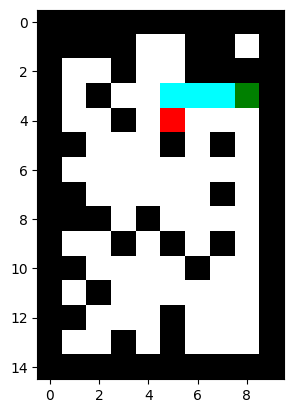

Step 1: State(x=5, y=4, steps_left=150, reward=0), action_probs: [0.         0.30830831 0.22822823 0.46346346] action chosen: Right
Step 2: State(x=6, y=4, steps_left=149, reward=-1), action_probs: [0.17417417 0.27427427 0.17117117 0.38038038] action chosen: Right
Step 3: State(x=7, y=4, steps_left=148, reward=-2), action_probs: [0.         0.38238238 0.18218218 0.43543544] action chosen: Right
Step 4: State(x=8, y=4, steps_left=147, reward=-3), action_probs: [0.18418418 0.61661662 0.1991992  0.        ] action chosen: Up


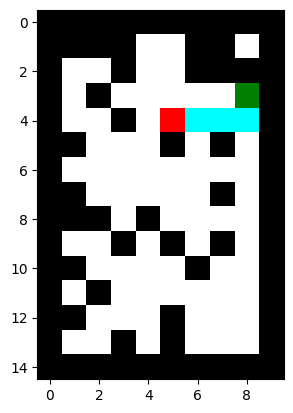

In [184]:
maze = Maze(10, 15)
maze.visualize_path()
mcts = MCTS(maze, 1000, 1.41)
mcts.play_game()